In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import IPython.display as ipd
from scipy import signal

### Constants

In [2]:
fs = 48000
N = 2048
K = 25
scale_bits = 4

### Exercise 8.9

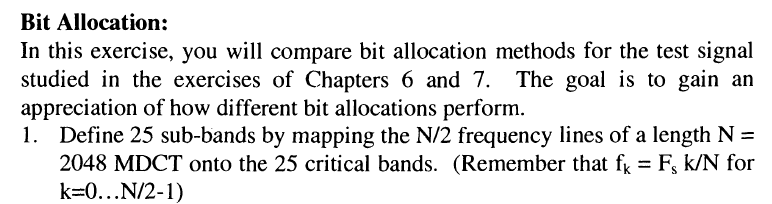

In [3]:
def bark(f): #Mapping to Bark Scale (25 subbands)
    return 13*np.arctan(.76*f/1000)+3.5*np.arctan((f/7500)**2)

def get_subband_index(f):
    return 1 + int(bark(f))

def bin_to_subband_index(k, fs=48000, N=2048):
    return 1 + int(bark(k * fs / N))

In [4]:
print(f"Bin {0} is equivalent to sub-band {bin_to_subband_index(0, fs, N)}")
print(f"Bin {512} is equivalent to sub-band {bin_to_subband_index(512, fs, N)}")
print(f"Bin {1023} is equivalent to sub-band {bin_to_subband_index(1023, fs, N)}")

Bin 0 is equivalent to sub-band 1
Bin 512 is equivalent to sub-band 24
Bin 1023 is equivalent to sub-band 25


In [5]:
k_map = {k:0 for k in range(1, K+1)}

for b in range(N//2): 
    k = bin_to_subband_index(b, fs, N)
    k_map[k] = k_map[k] + 1

k_map

{1: 5,
 2: 4,
 3: 5,
 4: 4,
 5: 5,
 6: 5,
 7: 6,
 8: 6,
 9: 7,
 10: 7,
 11: 9,
 12: 10,
 13: 11,
 14: 15,
 15: 17,
 16: 22,
 17: 26,
 18: 31,
 19: 36,
 20: 43,
 21: 52,
 22: 66,
 23: 96,
 24: 171,
 25: 365}

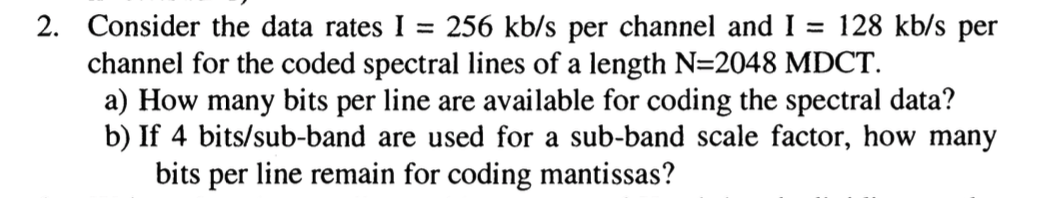

In [6]:
def R_k(data_rate, fs): # Average number of bits per coded sample
    return data_rate / fs


def block_bits_per_channel(R_k, N) : # Total number of bits in an MDCT block
    return R_k * N / 2

In [7]:
I_1 = 256000 # Data Rate 1
I_2 = 128000 # Data Rate 2

# Total number of bits
print(f"Total number of bits available (256 kb/s) = {int(block_bits_per_channel(R_k(I_1, fs), N))}")
print(f"Total number of bits available (128 kb/s) = {int(block_bits_per_channel(R_k(I_2, fs), N))}")

# Bits per line
bits_per_line = int(block_bits_per_channel(R_k(I_1, fs), N))*2/N
print(f"Bits per line (256 kb/s) = {bits_per_line}")

bits_per_line = int(block_bits_per_channel(R_k(I_2, fs), N))*2/N
print(f"Bits per line (128 kb/s) = {bits_per_line}")

# Bits per line after subtracting scale bits
scale_bits = 4
scale_bits_per_block = 4*K
print(f"\nRemoving {scale_bits} scale bits per sub-band... Total removed = {scale_bits_per_block}")

bits_per_line = int(block_bits_per_channel(R_k(I_1, fs), N) - scale_bits_per_block)*2/N
print(f"Remaining bits per line for mantissas (256 kb/s) = {bits_per_line}")

bits_per_line = int(block_bits_per_channel(R_k(I_2, fs), N) - scale_bits_per_block)*2/N
print(f"Remaining bits per line for mantissas (128 kb/s) = {bits_per_line}")

Total number of bits available (256 kb/s) = 5461
Total number of bits available (128 kb/s) = 2730
Bits per line (256 kb/s) = 5.3330078125
Bits per line (128 kb/s) = 2.666015625

Removing 4 scale bits per sub-band... Total removed = 100
Remaining bits per line for mantissas (256 kb/s) = 5.2353515625
Remaining bits per line for mantissas (128 kb/s) = 2.568359375


### Signal from chapters 6 and 7

In [8]:
class MDCT():
    def __init__(self, N: int, window: np.ndarray):
        K = N//2
        self.n_0 = ((N/2) + 1)/2

        A = np.zeros((K,N))
        for k in range(K):
            for n in range(N):
                A[k,n] = np.cos((2*np.pi/N)*(n + self.n_0)*(k+1/2))

        self.N = N
        self.window = window
        self.A_1 = A[:,:N//2]
        self.A_2 = A[:,N//2:]
        self.B_1 = (4/N)*self.A_1.T
        self.B_2 = (4/N)*self.A_2.T

        self.A = A
        self.B = (4/N)*A.T

        if window.shape[0] != N:
            raise ValueError(f"Window is not the same size as N! Window size: {window.shape[0]}")

    def _preprocess(self, x: np.ndarray):
        L = len(x)
        self.frames = L // (self.N // 2) + 2
        r = L % (self.N // 2)
        self.extra_pad = self.N // 2 - r
        return np.pad(x, (self.N // 2, self.N // 2 + self.extra_pad))


    def mdct(self, x: np.ndarray):
        x_padded = self._preprocess(x)

        X = np.ndarray((self.A.shape[0], self.frames))
        for frame_idx in range(self.frames):
            frame = x_padded[frame_idx*(self.N//2):frame_idx*(self.N//2)+self.N]
            X[:, frame_idx] = self.A @ (frame * self.window)

        return X

    def imdct(self, X: np.ndarray):
        x_padded = np.zeros(self.frames * self.N//2 + self.N//2)
        for frame_idx in range(self.frames):
            x_padded[frame_idx*self.N//2:frame_idx*self.N//2 + self.N] += (self.B @ X[:,frame_idx]) * self.window
            
        return x_padded[self.N//2:-self.N//2 - self.extra_pad]
    
    def mdct_pre_twiddle(self):
        return np.exp(-2j * np.pi * np.arange(self.N) / (2*self.N))

    def mdct_post_twiddle(self):
        return np.exp(-2j * np.pi * self.n_0 * (np.arange(self.N//2) + 0.5) / self.N)


    def mdct_via_fft(self, x):
        x_padded = self._preprocess(x)

        X = np.ndarray((self.A.shape[0], self.frames))
        for frame_idx in range(self.frames):
            frame = x_padded[frame_idx*(self.N//2):frame_idx*(self.N//2)+self.N]
            X[:, frame_idx] = np.real(
                self.mdct_post_twiddle() * np.fft.fft(frame * self.window * self.mdct_pre_twiddle())[:self.N//2]
            )
        
        return X 
    
    def imdct_pre_twiddle(self):
        return np.exp(2j * np.pi * self.n_0 * np.arange(self.N) / self.N)

    def imdct_post_twiddle(self):
        return np.exp(2j * np.pi * (np.arange(self.N) + self.n_0) / (2*self.N))
    
    def imdct_via_ifft(self, X):
        x_padded = np.zeros(self.frames * self.N//2 + self.N//2)
        for frame_idx in range(self.frames):
            x_padded[frame_idx*self.N//2:frame_idx*self.N//2 + self.N] += \
            np.real(np.fft.ifft(np.concatenate((X[:,frame_idx], -X[::-1,frame_idx])) * self.imdct_pre_twiddle()) * \
            self.imdct_post_twiddle()) * 2 * self.window
            
        return x_padded[self.N//2:-self.N//2 - self.extra_pad]

In [9]:
def sine_window(N):
    M = N//2
    w = np.zeros((N,1))

    for n in range(N-M):
        w[n] = np.sin((np.pi/2)*(n+1/2)/(N-M))
        
    for n in range(N-M,M):
        w[n] = 1

    for n in range(M,N):
        w[n] = np.sin((np.pi/2)*(N - n - 1/2)/(N-M))

    return w.reshape(-1)

In [10]:
n = np.arange(N)
T = N/fs
t = np.linspace(0, T, N)

A0 = 0.6
A1 = 0.55
A2 = 0.55
A3 = 0.15
A4 = 0.1
A5 = 0.05


x = A0 * np.cos(2 * np.pi * n * 440/fs) \
  + (A1 * np.cos(2 * np.pi * n * 554/fs)) \
  + (A2 * np.cos(2 * np.pi * n * 660/fs)) \
  + (A3 * np.cos(2 * np.pi * n * 880/fs)) \
  + (A4 * np.cos(2 * np.pi * n * 4400/fs)) \
  + (A5 * np.cos(2 * np.pi * n * 8800/fs))


x = x/2
my_mdct = MDCT(N, sine_window(N))

X_mdct = my_mdct.mdct(x)[:, 1]
X_mdct_max = np.max(np.abs(X_mdct))

mdct_bins = np.arange(X_mdct.shape[0])
mdct_freqs = (mdct_bins * fs / N)

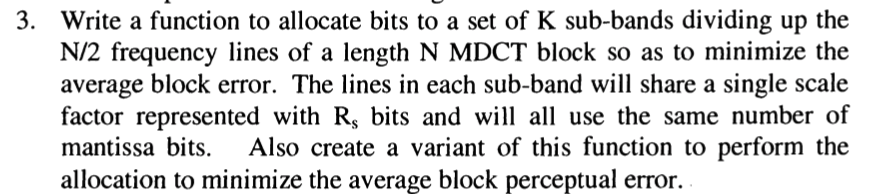

#### Uniform allocation

In [11]:
def uniform_allocation(total_bits, K):
    initial_allocation = (total_bits) // K * np.ones((K))
    remaining_bits = total_bits % K
    initial_allocation[np.random.permutation(K)[:remaining_bits]] += 1
    
    return initial_allocation

In [12]:
I_1 = 256000 # Data Rate 1
I_2 = 128000 # Data Rate 2

# Bits per line after subtracting scale bits
scale_bits = 4
scale_bits_per_block = 4*K
print(f"\nRemoving {scale_bits} scale bits per sub-band... Total removed = {scale_bits_per_block}")
uniform_alloc = uniform_allocation(int(block_bits_per_channel(R_k(I_1, fs), N) - scale_bits_per_block), K)
print(f"Uniform bit allocation  per sub-band for mantissas (256 kb/s) = {uniform_alloc}")
print(uniform_alloc.sum())
uniform_alloc = uniform_allocation(int(block_bits_per_channel(R_k(I_2, fs), N) - scale_bits_per_block), K)
print(f"Uniform bit allocation per sub-band for mantissas (128 kb/s) = {uniform_alloc}")


Removing 4 scale bits per sub-band... Total removed = 100
Uniform bit allocation  per sub-band for mantissas (256 kb/s) = [215. 214. 214. 215. 215. 214. 215. 215. 214. 215. 214. 214. 215. 215.
 215. 214. 214. 214. 215. 214. 214. 214. 215. 214. 214.]
5361.0
Uniform bit allocation per sub-band for mantissas (128 kb/s) = [105. 105. 105. 105. 105. 106. 105. 105. 105. 105. 105. 105. 106. 105.
 105. 105. 106. 105. 105. 106. 106. 105. 105. 105. 105.]


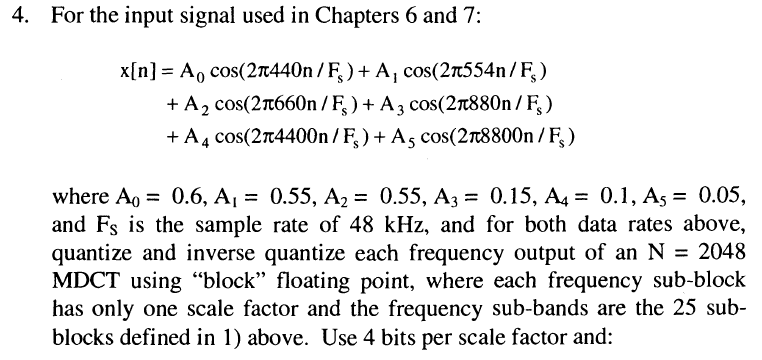

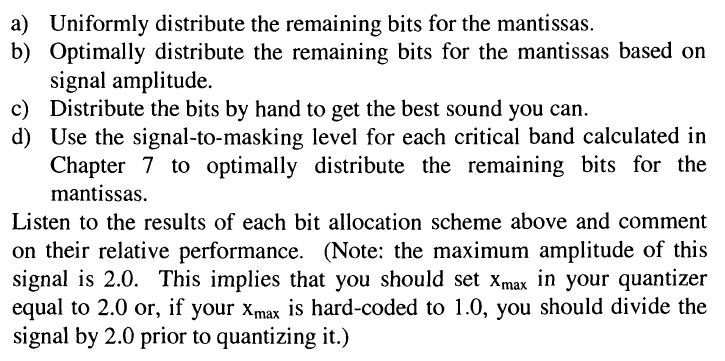

In [13]:
w = sine_window(N)
x_w = x[:N] * w
X_fft = np.fft.fftshift(np.fft.fft(x_w, n=N))
omega_fft = np.fft.fftshift(np.fft.fftfreq(N))

In [14]:
def spl_peaks(X, N_fft, N_w):
    bw_factor = N_fft / (2 * N_w)
    norm = (N_w * N_fft / 8)
    
    X_db = 20 * np.log10(np.abs(X) + np.finfo(float).eps)
    peaks, _ = signal.find_peaks(X_db, height=0.1, prominence=25)
    SPL = np.zeros(peaks.shape)
    for i, p in enumerate(peaks):
        peak_energy = np.sum(np.abs(X[p - int(np.ceil(3 * bw_factor)):p + int(np.ceil(3 * bw_factor))]) ** 2) / norm
        SPL[i] = 96 + 10 * np.log10(peak_energy + np.finfo(float).eps)
    
    return SPL, peaks

def spl(X, N_fft, N_w):
    bw_factor = N_fft / (2 * N_w)
    norm = (N_w * N_fft / 8)
    
    for i in range(X.shape[0]):
        lim_inf = i - int(np.ceil(3 * bw_factor))
        lim_sup = i + int(np.ceil(3 * bw_factor))
        if i < int(np.ceil(3 * bw_factor)):
            lim_inf = 0
        if i > X.shape[0] - int(np.ceil(3 * bw_factor)):
            lim_sup = -1

            
        peak_energy = np.sum(np.abs(X[lim_inf:lim_sup]) ** 2) / norm
        SPL[i] = 96 + 10 * np.log10(peak_energy + np.finfo(float).eps)
    
    return SPL

def spl_by_sample(X, N_fft, N_w):
    norm = (N_w * N_fft / 8)

    peak_energy = np.abs(X) ** 2 / norm
    return 96 + 10 * np.log10(peak_energy + np.finfo(float).eps)



In [15]:
def delta_tone_masking_noise(z, delta):
    return delta + z

def masking_model(bark, SPL, peaks, delta=15):
    sf_peaks = np.zeros((len(bark), len(bark)))
    
    teta = np.zeros_like(bark)
    for i in peaks:
        dz = bark - bark[i]
        teta[dz > 0] = 1
        
        # spreading function
        sf = ((-27 + 0.37 * np.max((SPL[i] - 40), 0) * teta) * np.abs(dz))
        
        # masking model
        sf_peaks[i,:] = np.maximum(SPL[i] + sf - delta_tone_masking_noise(bark[i], delta), 0)
     
    return sf_peaks

#Threshold in quiet
def hearing_threshold(mdct_freqs):
    mdct_freqs[0] = mdct_freqs[1]
    threshold = 3.64*(mdct_freqs/1000)**(-.8)-6.5*np.exp(-.6*(mdct_freqs/1000-3.3)**2)+10**(-3)*(mdct_freqs/1000)**4
    threshold_barks = bark(mdct_freqs)
    return (threshold_barks, threshold)

def higher_mask(mask_1, mask_2):
    return np.maximum(mask_1, mask_2)

In [16]:
SPL = spl_by_sample(X_mdct, N, N)
SPL_peaks, peaks = spl_peaks(X_mdct, N, N)
bark_freqs = bark(mdct_freqs)

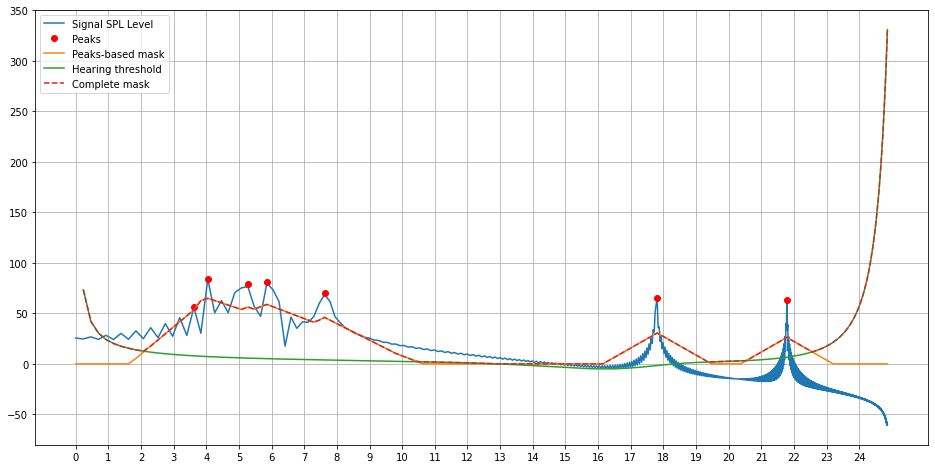

In [17]:
plt.figure(figsize=(16,8))
plt.plot(bark_freqs, SPL, label="Signal SPL Level")
plt.plot(bark_freqs[peaks], SPL_peaks, "ro", label="Peaks")
plt.xticks(np.arange(25))
plt.grid(True)

mask = np.max(masking_model(bark_freqs, SPL, peaks), axis=0)
plt.plot(bark_freqs, mask, label = "Peaks-based mask")

t_bark, thres = hearing_threshold(mdct_freqs)
plt.plot(t_bark, thres, label="Hearing threshold")

complete_mask = higher_mask(thres, mask)
plt.plot(t_bark, complete_mask, "--", label="Complete mask")

plt.legend()

#### Optimal error bit allocation

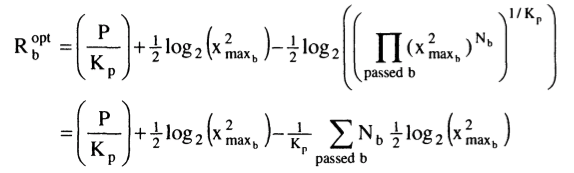

In [18]:
def bit_allocation(K_p: int, P: int, N_b: np.ndarray, xmax_b: np.ndarray):
#     xmax_b = xmax_b / np.min(xmax_b)
    avg = np.sum(0.5 * np.array(N_b) * np.log2(xmax_b ** 2))/K_p
    buffer = np.array((P/K_p) + 0.5 * np.log2(xmax_b ** 2) - avg)
        
    return np.floor(buffer)

In [19]:
def bit_allocation_greedy(K_p, P, N_b, xmax_b):
    avg = np.sum(0.5 * np.array(N_b) * np.log2(xmax_b ** 2))/K_p
    buffer = np.array((P/K_p) + 0.5 * np.log2(xmax_b ** 2) - avg)
    
    positives = np.ones_like(buffer)
    while np.any(buffer < 0):
        positives[np.nonzero(buffer < 0)[0]] = 0
        K_p = np.sum(Nb*positives)
        
        avg = np.sum(0.5 * np.array(N_b) * np.log2(xmax_b ** 2) * positives) / K_p
        buffer = np.array((P/K_p) + 0.5 * np.log2(xmax_b ** 2) - avg) * positives
        
    return np.floor(buffer)

In [20]:
def waterfilling(x_max_b, Nb, total_bits):
    threshold = np.log2(np.max(x_max_b))
    t_inf = np.log2(np.min(x_max_b))
    
    sub_band_bits = np.zeros_like(x_max_b)
    bits_allocated = 0
    x_max_b_sorted_idxs = np.argsort(x_max_b)[::-1]
    remaining_bits = total_bits
    
    while bits_allocated < total_bits:
        for i in x_max_b_sorted_idxs:
            if np.log2(x_max_b[i]) >= threshold and bits_allocated < total_bits and remaining_bits >= Nb[i]:
                sub_band_bits[i] += Nb[i]
                bits_allocated += Nb[i]
                remaining_bits = total_bits - bits_allocated
                
            if remaining_bits < Nb[i]:
                return sub_band_bits
            
        if threshold > t_inf:
            threshold -= 1
        else:
            threshold = t_inf
            
    return sub_band_bits

In [21]:
diff = SPL - complete_mask
positive_diff_idx = np.nonzero(diff > 0)[0]
# print(positive_diff_idx.shape)
# print(positive_diff_idx)
barks_to_pass = bark_freqs[positive_diff_idx]
# print(bark_to_pass.shape)
# print(bark_to_pass)

bands_to_pass = np.array(list({np.floor(b) for b in barks_to_pass}), dtype=np.int64)
print(bands_to_pass.shape)
print(bands_to_pass)

(17,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 17 21]


In [22]:
df = pd.DataFrame({'bin': range(1024), 'mdct': X_mdct / X_mdct_max})
df["subband"] = df["bin"].apply(bin_to_subband_index)
df.drop(columns = ["bin"], inplace = True)
df['x_k'] = df['mdct'].apply(lambda x: 2 ** np.ceil(np.log2(x)))
df['scale_bits'] = df['mdct'].apply(lambda x: np.ceil(np.log2(x)))
x_max_b = df.groupby(by=["subband"]).max()["scale_bits"].to_numpy()
x_max_b_sorted_idxs = np.argsort(x_max_b)[::-1]
x_max_b = df.groupby(by=["subband"]).max()["x_k"].to_numpy()

In [23]:
passed = np.zeros(K)
passed[bands_to_pass] += 1
passed = passed.astype(np.int64)

K = len(k_map)
Nb = np.array(list(k_map.values()))
total_bits = int(block_bits_per_channel(R_k(I_1, fs), N) - 100)

Kp = (Nb * passed).sum()
Nb_p = Nb * passed
Nb_p = Nb_p[Nb_p != 0].astype(np.int64)
x_max_b_p = x_max_b * passed
x_max_b_p = x_max_b_p[x_max_b_p != 0]

In [24]:
start_time = time.time()
allocation = bit_allocation(Kp, total_bits, Nb_p, x_max_b_p)
print('time: ', time.time() - start_time)
int_allocation = np.floor(allocation)

print("Total bits available:", total_bits, "\n")
print( "Bit allocation (normal) per subband: \n\n", allocation, "\n")
print( "Int bit allocation (normal) per subband: \n\n", int_allocation, "\n")
print ("\nTotal number of allocated bits:", np.sum(allocation * Nb_p))
print ("\nTotal number of int allocated bits:", np.sum(int_allocation * Nb_p))
print ("\nRemaing bits:", int(total_bits - np.sum(int_allocation * Nb_p)))

time:  0.0001971721649169922
Total bits available: 5361 

Bit allocation (normal) per subband: 

 [22. 23. 24. 25. 29. 30. 28. 28. 23. 21. 21. 20. 19. 19. 18. 27. 28.] 

Int bit allocation (normal) per subband: 

 [22. 23. 24. 25. 29. 30. 28. 28. 23. 21. 21. 20. 19. 19. 18. 27. 28.] 


Total number of allocated bits: 5235.0

Total number of int allocated bits: 5235.0

Remaing bits: 126


In [25]:
start_time = time.time()
allocation = bit_allocation_greedy(Kp, total_bits, Nb_p, x_max_b_p)
print('time: ', time.time() - start_time)
int_allocation = np.floor(allocation)

print("Total bits available:", total_bits, "\n")
print( "Bit allocation (greedy) per subband: \n\n", allocation, "\n")
print( "Int bit allocation (greedy) per subband: \n\n", int_allocation, "\n")
print ("\nTotal number of allocated bits:", np.sum(allocation * Nb_p))
print ("\nTotal number of int allocated bits:", np.sum(int_allocation * Nb_p))
print ("\nRemaing bits:", int(total_bits - np.sum(int_allocation * Nb_p)))

time:  0.0002491474151611328
Total bits available: 5361 

Bit allocation (greedy) per subband: 

 [22. 23. 24. 25. 29. 30. 28. 28. 23. 21. 21. 20. 19. 19. 18. 27. 28.] 

Int bit allocation (greedy) per subband: 

 [22. 23. 24. 25. 29. 30. 28. 28. 23. 21. 21. 20. 19. 19. 18. 27. 28.] 


Total number of allocated bits: 5235.0

Total number of int allocated bits: 5235.0

Remaing bits: 126


In [26]:
start_time = time.time()
sub_band_bits = waterfilling(x_max_b_p, Nb_p, total_bits)
print('time: ', time.time() - start_time)
sub_band_bits.sum(), sub_band_bits

time:  0.003078460693359375


(5311.0,
 array([ 110.,   92.,  120.,  100.,  150.,  155.,  168.,  168.,  161.,
         147.,  189.,  200.,  209.,  285.,  306.,  837., 1914.]))

In [27]:
sub_band_bits / Nb_p

array([22., 23., 24., 25., 30., 31., 28., 28., 23., 21., 21., 20., 19.,
       19., 18., 27., 29.])

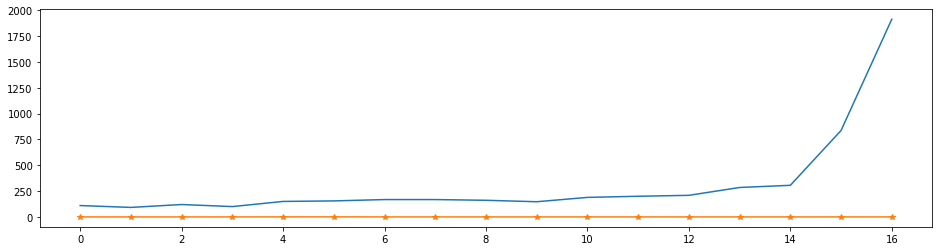

In [28]:
fig, ax = plt.subplots(figsize=(16,4))
plt.plot(waterfilling(x_max_b_p, Nb_p, total_bits))
plt.plot(x_max_b_p, "*-")

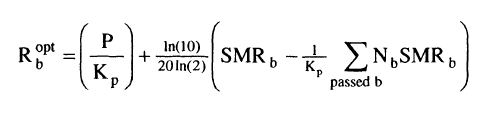

In [29]:
def bit_allocation_perceptual(K_p, P, Nb, SMR_b):
#     SMR_b = SMR_b / np.min(SMR_b)
    avg = np.sum(SMR_b * np.array(Nb))/K_p
    buffer = np.array((P/K_p) + (np.log(10) / (20 * np.log(2))) * (SMR_b - avg))
        
    return np.floor(buffer)

In [30]:
def bit_allocation_perceptual_greedy(K_p, P, N_b, SMR_b):
    avg = np.sum(np.array(N_b) * SMR_b)/K_p
    buffer = np.array((P/K_p) + (np.log(10) / (20 * np.log(2))) * (SMR_b - avg))
    
    positives = np.ones_like(buffer)
    while np.any(buffer < 0):
        positives[np.nonzero(buffer < 0)[0]] = 0
        K_p = np.sum(Nb*positives)
        
        avg = np.sum(np.array(N_b) * SMR_b * positives)/K_p
        buffer = np.array((P/K_p) + (np.log(10) / (20 * np.log(2))) * (SMR_b - avg)) * positives
        
    return np.floor(buffer)

In [31]:
def waterfilling_perceptual(SMR_b, Nb, total_bits):
    threshold = np.max(SMR_b)
    t_inf = np.min(SMR_b)
    
    sub_band_bits = np.zeros_like(SMR_b)
    bits_allocated = 0
    SMR_b_sorted_idxs = np.argsort(SMR_b)[::-1]
    remaining_bits = total_bits
    
    while bits_allocated < total_bits:
        for i in SMR_b_sorted_idxs:
            if SMR_b[i] >= threshold and bits_allocated < total_bits and remaining_bits >= Nb[i]:
                sub_band_bits[i] += Nb[i]
                bits_allocated += Nb[i]
                remaining_bits = total_bits - bits_allocated
                
            if remaining_bits < Nb[i]:
                return sub_band_bits
            
        if threshold > t_inf:
            threshold -= 6
        else:
            threshold = t_inf
            
    return sub_band_bits

In [32]:
SMR = SPL - complete_mask

df = pd.DataFrame({'bin': range(1024), 'smr': SMR})
df["subband"] = df["bin"].apply(bin_to_subband_index)
df.drop(columns = ["bin"], inplace = True)
smr_b = df.groupby(by=["subband"]).max()["smr"].to_numpy()

smr_b_p = smr_b * passed
smr_b_p = smr_b_p[smr_b_p != 0]

In [33]:
allocation = bit_allocation_perceptual(Kp, total_bits, Nb_p, smr_b_p)
allocation_greedy = bit_allocation_perceptual_greedy(Kp, total_bits, Nb_p, smr_b_p)
allocation_waterfilling = waterfilling_perceptual(smr_b_p, Nb_p, total_bits)

print("Total bits available:", total_bits, "\n")
print( "Bit allocation (normal) per subband: \n\n", allocation, "\n")
print( "Int bit allocation (normal) per subband: \n\n", np.floor(allocation), "\n")
print ("\nTotal number of allocated bits:", np.sum(allocation * Nb_p))
print ("\nTotal number of int allocated bits:", np.sum(np.floor(allocation) * Nb_p))
print ("\nRemaing bits:", int(total_bits - np.sum(np.floor(allocation) * Nb_p)))
print("="*10)
print("Total bits available:", total_bits, "\n")
print( "Bit allocation (greedy) per subband: \n\n", allocation_greedy, "\n")
print( "Int bit allocation (greedy) per subband: \n\n", np.floor(allocation_greedy), "\n")
print ("\nTotal number of allocated bits:", np.sum(allocation_greedy * Nb_p))
print ("\nTotal number of int allocated bits:", np.sum(np.floor(allocation_greedy) * Nb_p))
print ("\nRemaing bits:", int(total_bits - np.sum(np.floor(allocation_greedy) * Nb_p)))
print("="*10)
print("Total bits available:", total_bits, "\n")
print( "Bit allocation (waterfilling) per subband: \n\n", allocation_waterfilling, "\n")
print ("\nTotal number of allocated bits:", np.sum(allocation_waterfilling))
print ("\nRemaing bits:", int(total_bits - np.sum(np.floor(allocation_waterfilling))))

Total bits available: 5361 

Bit allocation (normal) per subband: 

 [22. 24. 24. 22. 24. 25. 24. 25. 22. 23. 23. 23. 22. 22. 21. 27. 27.] 

Int bit allocation (normal) per subband: 

 [22. 24. 24. 22. 24. 25. 24. 25. 22. 23. 23. 23. 22. 22. 21. 27. 27.] 


Total number of allocated bits: 5253.0

Total number of int allocated bits: 5253.0

Remaing bits: 108
Total bits available: 5361 

Bit allocation (greedy) per subband: 

 [22. 24. 24. 22. 24. 25. 24. 25. 22. 23. 23. 23. 22. 22. 21. 27. 27.] 

Int bit allocation (greedy) per subband: 

 [22. 24. 24. 22. 24. 25. 24. 25. 22. 23. 23. 23. 22. 22. 21. 27. 27.] 


Total number of allocated bits: 5253.0

Total number of int allocated bits: 5253.0

Remaing bits: 108
Total bits available: 5361 

Bit allocation (waterfilling) per subband: 

 [ 110.  100.  120.   88.  125.  125.  144.  150.  154.  161.  216.  230.
  253.  330.  357.  837. 1848.] 


Total number of allocated bits: 5348.0

Remaing bits: 13


In [34]:
allocation_waterfilling / Nb_p

array([22., 25., 24., 22., 25., 25., 24., 25., 22., 23., 24., 23., 23.,
       22., 21., 27., 28.])

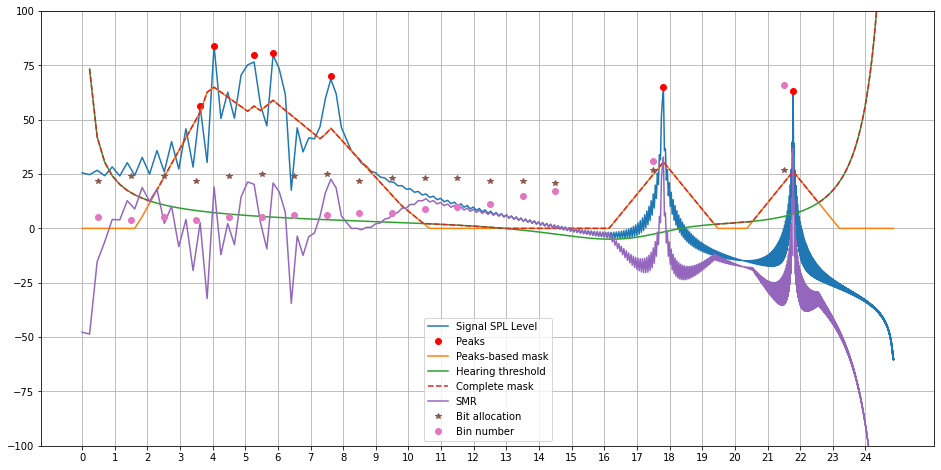

In [35]:
plt.figure(figsize=(16,8))
plt.plot(bark_freqs, SPL, label="Signal SPL Level")
plt.plot(bark_freqs[peaks], SPL_peaks, "ro", label="Peaks")
plt.xticks(np.arange(25))
plt.grid(True)

mask = np.max(masking_model(bark_freqs, SPL, peaks), axis=0)
plt.plot(bark_freqs, mask, label = "Peaks-based mask")

t_bark, thres = hearing_threshold(mdct_freqs)
plt.plot(t_bark, thres, label="Hearing threshold")

complete_mask = higher_mask(thres, mask)
plt.plot(t_bark, complete_mask, "--", label="Complete mask")

plt.plot(bark_freqs, SMR, label="SMR")

plt.plot(bands_to_pass + 1/2, np.floor(allocation), "*", label="Bit allocation")
plt.plot(bands_to_pass + 1/2, Nb_p, "o", label="Bin number")

plt.ylim(-100, 100)

plt.legend()

In [36]:
def count_zeros(x: int, R: int):
    """
    Shifts x by one until leftmost bit does not become 1.
    
    Args:
        x (int): Number to count leading zeros. 
        R (int): Total number of bits, defined by 2^R_s - 1 + R_m
    """
    
    res = 0
    if x == 0:
        return R
    while ((x & (1 << (R - 1))) == 0):
        x = (x << 1)
        res += 1
 
    return res

def code_uniform_midtread(number, R):
    if number>=0:
        signal=1
    else:
        signal=-1
    if abs(number)>=1:
        output=2**(R-1)-1
    else:
        output=int( ((2**R-1)*abs(number) + 1)/2 )
    
    return signal*output

def decode_uniform_midtread(code,R):
    signal = 2*int(code&2**(R-1)==0) - 1 
    number_abs = 2*abs(code)/(2**R-1)
    return signal*number_abs

def get_scale(x):
    return 2**(-count_zeros(code_uniform_midtread(x , 6) ,6) + 1)

In [37]:
def block_fp_quantizer(samples_b, n_bits_mantissa_b, n_bits_scale: int = 4): # nivel de sub-banda
    Nb = samples_b.shape[0]
    R_m = int(n_bits_mantissa_b // Nb)
    r = int(n_bits_mantissa_b % Nb)
    
    if r == 0:
        R = int(2 ** n_bits_scale - 1 + R_m)
        scales = np.zeros_like(samples_b) # escalas das amostras de uma unica sub-banda
        for i, v in enumerate(samples_b):
            leading_zeros = count_zeros(code_uniform_midtread(np.abs(v), R), R) - 1
            if leading_zeros < 2 ** n_bits_scale - 1:
                scales[i] = 2 ** n_bits_scale - 1 - leading_zeros
        max_scale = scales.max()
        quant_samples = np.zeros_like(samples_b)
        
        for i, v in enumerate(samples_b):
            quant_number = code_uniform_midtread(np.abs(v), R)
            quant_samples[i] = quant_number >> int(max_scale) # right bit shift
            s = np.abs(np.sign(v) - 1) // 2
            quant_samples[i] += int(s) << (R_m - 1) # left bit shift => primeiro bit da esquerda da mantissa
    else:
        mantissas = np.full_like(samples_b, R_m) # Primeiro, todas as amostras recebem as mantissas merecidas
        mantissas[:r] += 1 # Depois, as amostras que ganharam mais bits para mantissa as recebem
        scales = np.zeros_like(samples_b) # escalas das amostras de uma unica sub-banda
        for i, v in enumerate(samples_b):
            R = 2 ** n_bits_scale - 1 + int(mantissas[i])
            leading_zeros = count_zeros(code_uniform_midtread(np.abs(v), R), R) - 1
            if leading_zeros < 2 ** n_bits_scale - 1:
                scales[i] = 2 ** n_bits_scale - 1 - leading_zeros
        max_scale = scales.max()
        quant_samples = np.zeros_like(samples_b)
        
        for i, v in enumerate(samples_b):
            if (mantissas[i] != 0):
                R = 2 ** n_bits_scale - 1 + int(mantissas[i])
                quant_number = code_uniform_midtread(np.abs(v), R)
                quant_samples[i] = quant_number >> int(max_scale) # right bit shift
                s = np.abs(np.sign(v) - 1) // 2
                quant_samples[i] += int(s) << (int(mantissas[i]) - 1) # left bit shift => primeiro bit da esquerda da mantissa
            else:
                quant_samples[i] = 0
    return quant_samples, max_scale

In [38]:
def block_fp_dequantizer(coded_samples_b,  block_scale, n_bits_mantissa_b, n_bits_scale: int = 4):
    Nb = coded_samples_b.shape[0]
    R_m = int(n_bits_mantissa_b // Nb)
    r = int(n_bits_mantissa_b % Nb)
    decoded_samples = np.zeros_like(coded_samples_b, dtype=float)
    if r == 0:
        R = 2 ** n_bits_scale - 1 + R_m
        shift_value = 2**n_bits_scale-1-block_scale
        for i, v in enumerate(coded_samples_b):
            sign_bit = int(int(v)&(2**(R_m-1))!=0)
            s = (-2)*sign_bit + 1
            if block_scale != 0:
                v_no_s_bit = int(v) & (2**(R_m) - 1 - (1 << R_m - 1)) 
                decoded_samples[i] = s*decode_uniform_midtread((int(v_no_s_bit) << int(block_scale)) + 0*(1 << int(block_scale) - 1), R)
            else:
                v_no_s_bit = int(v) & (2**(R_m) - 1 - (1 << R_m - 1))
                decoded_samples[i] = s*decode_uniform_midtread(v_no_s_bit, R)
    else:
        mantissas = np.full_like(coded_samples_b, R_m) # Primeiro, todas as amostras recebem as mantissas merecidas
        mantissas[:r] += 1 # Depois, as amostras que ganharam mais bits para mantissa as recebem
        shift_value = 2**n_bits_scale-1-block_scale
        for i, v in enumerate(coded_samples_b):
            if mantissas[i] != 0:
                R = 2 ** n_bits_scale - 1 + int(mantissas[i])
                sign_bit = int(int(v) & int(2**(int(mantissas[i])-1))!=0)
                s = (-2)*sign_bit + 1
                if block_scale != 0:
                    v_no_s_bit = int(v) & (2**(int(mantissas[i])) - 1 - (1 << int(mantissas[i]) - 1)) 
                    decoded_samples[i] = s*decode_uniform_midtread((int(v_no_s_bit) << int(block_scale)) + 0*(1 << int(block_scale) - 1), R)
                else:
                    v_no_s_bit = int(v) & (2**(int(mantissas[i])) - 1 - (1 << int(mantissas[i]) - 1))
                    decoded_samples[i] = s*decode_uniform_midtread(v_no_s_bit, R)
            else:
                decoded_samples[i] = 0
        
    return decoded_samples

In [39]:
def sine_window(N):
    M = N//2
    w = np.zeros((N,1))

    for n in range(N-M):
        w[n] = np.sin((np.pi/2)*(n+1/2)/(N-M))
        
    for n in range(N-M,M):
        w[n] = 1

    for n in range(M,N):
        w[n] = np.sin((np.pi/2)*(N - n - 1/2)/(N-M))

    return w.reshape(-1)

In [40]:
def code_and_decode_vector(
    input_vector: np.ndarray,
    N: int,
    fs: int,
    n_scale_bits: int,
    I: int,
    window: np.ndarray = None,
    allocation_scheme: str = 'uniform',
    allocation_strategy: str = 'waterfilling',
    scale_norm: bool = True
):
    if window == None:
        mdct_transformer = MDCT(N, sine_window(N))
    else:
        assert (N == window.shape[0])
        mdct_transformer = MDCT(N, window)
    
    K = 25 # Numero de subbandas
    input_mdct = mdct_transformer.mdct_via_fft(input_vector)
    Frames = input_mdct.shape[1]
    quant_mdct = np.zeros_like(input_mdct)
    k_map = {k:0 for k in range(1, K+1)}
    for freq_bin in range(N//2): 
        k = bin_to_subband_index(freq_bin, fs, N)
        k_map[k] = k_map[k] + 1
        
    Nb = np.array(list(k_map.values()))
    Kp = Nb.sum()
    total_number_of_bits = int(block_bits_per_channel(R_k(I, fs), N) - K*n_scale_bits)
    max_value = np.max(input_mdct)
    for frame in range(Frames):
        
        current_frame = input_mdct[:, frame]
        # Calculo dos indices de frequência
        mdct_bins = np.arange(N // 2)
        mdct_freqs = (mdct_bins * fs / N)
        bark_freqs = bark(mdct_freqs)
        
        ### Alocação de bits:
        if allocation_scheme == 'uniform':
            allocation = uniform_allocation(total_number_of_bits, K)
            
        elif allocation_scheme == 'optimal_error':
            
            if scale_norm == False:
                ### Transformar esse bloco em uma funcao, talvez?############
                df = pd.DataFrame({'bin': range(N//2), 'mdct': current_frame})
                df["subband"] = df["bin"].apply(bin_to_subband_index, args=(fs, N))
                df.drop(columns = ["bin"], inplace = True)
                df['scale_bits'] = df['mdct'].apply(lambda x: np.ceil(np.log2(np.abs(x) + 0.0001)))
                x_max_b = df.groupby(by=["subband"]).max()["scale_bits"].to_numpy()
                ##############################################################
            else:
                df = pd.DataFrame({'bin': range(N//2), 'mdct': current_frame / max_value})
                df["subband"] = df["bin"].apply(bin_to_subband_index, args=(fs, N))
                df.drop(columns = ["bin"], inplace = True)
                df['scale_bits'] = df['mdct'].apply(lambda x: max_value * get_scale(x))
                x_max_b = df.groupby(by=["subband"]).max()["scale_bits"].to_numpy()

            
            if allocation_strategy == 'normal':
                allocation = bit_allocation(Kp, total_number_of_bits, Nb, x_max_b)
                allocation = allocation * Nb
                
            elif allocation_strategy == 'waterfilling':
                allocation = waterfilling(x_max_b, Nb, total_number_of_bits)

            elif allocation_strategy == 'greedy':
                allocation = bit_allocation_greedy(Kp, total_number_of_bits, Nb, x_max_b)
                allocation = allocation * Nb
                if np.any(np.isnan(allocation)):
                    allocation = uniform_allocation(total_number_of_bits, K)
                
            else:
                raise ValueError("No Such Strategy as " + allocation_strategy)

            
        elif allocation_scheme == 'perceptual':
            
            if scale_norm == False:
                SPL = spl_by_sample(current_frame, N, N)
                SPL_peaks, peaks = spl_peaks(current_frame, N, N)
                mask = np.max(masking_model(bark_freqs, SPL, peaks), axis=0)
                t_bark, thres = hearing_threshold(mdct_freqs)
                complete_mask = higher_mask(thres, mask)
                SMR = SPL - complete_mask
            else:
                df = pd.DataFrame({'bin': range(N//2), 'mdct': current_frame / max_value})
                df["subband"] = df["bin"].apply(bin_to_subband_index, args=(fs, N))
                df.drop(columns = ["bin"], inplace = True)
                df['scale_bits'] = df['mdct'].apply(lambda x: max_value * get_scale(x))
                x_max_b = df.groupby(by=["subband"]).max()["scale_bits"].to_numpy()
                
                SPL = spl(x_max_b, N, N)
                SPL_peaks, peaks = spl_peaks(current_frame, N, N)
                mask = np.max(masking_model(bark_freqs, SPL, peaks), axis=0)
                t_bark, thres = hearing_threshold(mdct_freqs)
                complete_mask = higher_mask(thres, mask)
                SMR = SPL - complete_mask
            
            ### Transformar esse bloco em uma funcao, talvez?#########
            df = pd.DataFrame({'bin': range(N//2), 'smr': SMR})
            df["subband"] = df["bin"].apply(bin_to_subband_index, args=(fs, N))
            df.drop(columns = ["bin"], inplace = True)
            smr_b = df.groupby(by=["subband"]).max()["smr"].to_numpy()
            ##########################################################
            
            if allocation_strategy == 'normal':
                allocation = bit_allocation_perceptual(Kp, total_number_of_bits, Nb, smr_b)
                allocation = allocation * Nb
            elif allocation_strategy == 'waterfilling':
                allocation = waterfilling_perceptual(smr_b, Nb, total_number_of_bits)
            
            elif allocation_strategy == 'greedy':
                allocation = bit_allocation_perceptual_greedy(Kp, total_number_of_bits, Nb, smr_b)
                allocation = allocation * Nb
                if np.any(np.isnan(allocation)):
                    allocation = uniform_allocation(total_number_of_bits, K)
            
            else:
                raise ValueError("No Such Strategy as " + allocation_strategy)
        else:
            raise ValueError("No Such Scheme as " + allocation_scheme)
        
        ## Quantização e Dequantização
        normalization_constant = max_value
        current_frame = current_frame/normalization_constant
        for k in range(K):
            mantissa_bits = allocation[k] if not np.isnan(allocation[k]) else 0 # Mantissa bits for that subband
            if mantissa_bits != 0:
                coded_samples, band_scale = block_fp_quantizer(current_frame[np.floor(bark_freqs) == k], mantissa_bits, n_scale_bits)
                decoded_samples = block_fp_dequantizer(coded_samples, band_scale, mantissa_bits, n_scale_bits)
                quant_mdct[np.floor(bark_freqs) == k, frame] = decoded_samples
            else:
                quant_mdct[np.floor(bark_freqs) == k, frame] = 0
        
        quant_mdct[:, frame] *= normalization_constant
        
    output_vector = mdct_transformer.imdct_via_ifft(quant_mdct)
    return output_vector

In [41]:
n = np.arange(N*200)
T = N/fs
t = np.linspace(0, T, N)

A0 = 0.6
A1 = 0.55
A2 = 0.55
A3 = 0.15
A4 = 0.1
A5 = 0.05


x = A0 * np.cos(2 * np.pi * n * 440/fs) \
  + (A1 * np.cos(2 * np.pi * n * 554/fs)) \
  + (A2 * np.cos(2 * np.pi * n * 660/fs)) \
  + (A3 * np.cos(2 * np.pi * n * 880/fs)) \
  + (A4 * np.cos(2 * np.pi * n * 4400/fs)) \
  + (A5 * np.cos(2 * np.pi * n * 8800/fs))


x = x/2

In [42]:
# out = code_and_decode_vector(x, 2048, fs, 4, I_1, allocation_scheme = 'optimal_error', allocation_strategy = 'normal', scale_norm=True)

In [43]:
# plt.plot(np.abs(x - out)[1000:-1000])

In [44]:
# sound = ipd.Audio(x, rate=fs)
# sound

In [45]:
# out_sound = ipd.Audio(out, rate=fs)
# out_sound

In [46]:
import glob
import os
from scipy.io.wavfile import read, write

In [47]:
lw_files = glob.glob('../../data/audios_lw/*.wav', recursive=True)

In [48]:
moreno_files = glob.glob('../../data/audios_moreno/*/*.wav', recursive=True)

In [49]:
def run_codec(
    filename: str,
    conf: dict,
    N: int = 2048,
    scale_bits: int = 4,
    window = None
):
    print(f"Audio: {filename}")       
    sr, audio = read(filename)
    print(f"This audio file has shape {audio.shape}.")
    print(f"This audio file has {audio.shape[-1]} channels.")
    
    for b in conf['bit_rates']:
        for all_scheme in conf['allocation_scheme']:
            for all_strat in conf['allocation_strategy']:
                print(f"Bit rate: {b}\tAllocation scheme: {all_scheme}\tAllocation strategy: {all_strat}")
                codec_audio = np.zeros_like(audio)
                for c in range(audio.shape[-1]):
                    in_audio = audio[:, c]
                    codec_audio[:, c] = code_and_decode_vector(
                        in_audio, N, sr, scale_bits, b,
                        window=window,
                        allocation_scheme=all_scheme,
                        allocation_strategy=all_strat,
                        scale_norm=True
                    )
                f = os.path.basename(filename).replace('.wav', '')
                filepath = f"../../data/outputs/{sr}/{f}-dubi-{int(b/1000)}.wav"
                print(f"Saving codec audio in {filepath}...")
                write(f"../../data/outputs/{sr}/{f}-dubi-{int(b/1000)}.wav", sr, codec_audio)

In [59]:
conf = {
    'bit_rates': [96000, 128000, 192000, 256000, 320000],
    'allocation_scheme': ['perceptual'],
    'allocation_strategy': ['waterfilling']
}
for f in lw_files:
    run_codec(f, conf)

Audio: ../../data/audios_lw/Valsa_Chopin-Godowsky_1916.wav
This audio file has shape (712656, 2).
This audio file has 2 channels.
Bit rate: 96000	Allocation scheme: perceptual	Allocation strategy: waterfilling


/tmp/ipykernel_14173/1614529085.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = read(filename)


Saving codec audio in ../../data/outputs/44100/Valsa_Chopin-Godowsky_1916-dubi-96.wav...
Bit rate: 128000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/44100/Valsa_Chopin-Godowsky_1916-dubi-128.wav...
Bit rate: 192000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/44100/Valsa_Chopin-Godowsky_1916-dubi-192.wav...
Bit rate: 256000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/44100/Valsa_Chopin-Godowsky_1916-dubi-256.wav...
Bit rate: 320000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/44100/Valsa_Chopin-Godowsky_1916-dubi-320.wav...
Audio: ../../data/audios_lw/Royer-cravo.wav
This audio file has shape (628261, 2).
This audio file has 2 channels.
Bit rate: 96000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data

In [57]:
filtered_moreno_files = [f for f in moreno_files if 'mp3' not in f and 'ogg' not in f and 'wma' not in f]

In [58]:
conf = {
    'bit_rates': [96000, 128000, 192000, 256000, 320000],
    'allocation_scheme': ['perceptual'],
    'allocation_strategy': ['waterfilling']
}
for f in filtered_moreno_files:
    run_codec(f, conf)

Audio: ../../data/audios_moreno/dubal/dubal.wav
This audio file has shape (676719, 2).
This audio file has 2 channels.
Bit rate: 96000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/48000/dubal-dubi-96.wav...
Bit rate: 128000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/48000/dubal-dubi-128.wav...
Bit rate: 192000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/48000/dubal-dubi-192.wav...
Bit rate: 256000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/48000/dubal-dubi-256.wav...
Bit rate: 320000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/48000/dubal-dubi-320.wav...
Audio: ../../data/audios_moreno/blues/blues.wav
This audio file has shape (1056000, 2).
This audio file has 2 channels.
Bit rate: 960

/tmp/ipykernel_14173/1614529085.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = read(filename)


Saving codec audio in ../../data/outputs/48000/valsa-dubi-96.wav...
Bit rate: 128000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/48000/valsa-dubi-128.wav...
Bit rate: 192000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/48000/valsa-dubi-192.wav...
Bit rate: 256000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/48000/valsa-dubi-256.wav...
Bit rate: 320000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/48000/valsa-dubi-320.wav...
Audio: ../../data/audios_moreno/schulz/schulz.wav
This audio file has shape (609600, 2).
This audio file has 2 channels.
Bit rate: 96000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/48000/schulz-dubi-96.wav...
Bit rate: 128000	Allocation scheme: perceptual	Allocation stra

In [60]:
conf = {
    'bit_rates': [512000],
    'allocation_scheme': ['perceptual'],
    'allocation_strategy': ['waterfilling']
}
for f in lw_files:
    run_codec(f, conf)

Audio: ../../data/audios_lw/Valsa_Chopin-Godowsky_1916.wav
This audio file has shape (712656, 2).
This audio file has 2 channels.
Bit rate: 512000	Allocation scheme: perceptual	Allocation strategy: waterfilling


/tmp/ipykernel_14173/1614529085.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = read(filename)


Saving codec audio in ../../data/outputs/44100/Valsa_Chopin-Godowsky_1916-dubi-512.wav...
Audio: ../../data/audios_lw/Royer-cravo.wav
This audio file has shape (628261, 2).
This audio file has 2 channels.
Bit rate: 512000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/44100/Royer-cravo-dubi-512.wav...
Audio: ../../data/audios_lw/HaGenteAqui-MJ.wav
This audio file has shape (934920, 2).
This audio file has 2 channels.
Bit rate: 512000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/44100/HaGenteAqui-MJ-dubi-512.wav...
Audio: ../../data/audios_lw/BluesInG_MJQ.wav
This audio file has shape (970200, 2).
This audio file has 2 channels.
Bit rate: 512000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/44100/BluesInG_MJQ-dubi-512.wav...
Audio: ../../data/audios_lw/Largo_Schulz-hv.wav
This audio file has shape (560070, 2).
Th

In [61]:
conf = {
    'bit_rates': [512000],
    'allocation_scheme': ['perceptual'],
    'allocation_strategy': ['waterfilling']
}
for f in filtered_moreno_files:
    run_codec(f, conf)

Audio: ../../data/audios_moreno/dubal/dubal.wav
This audio file has shape (676719, 2).
This audio file has 2 channels.
Bit rate: 512000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/48000/dubal-dubi-512.wav...
Audio: ../../data/audios_moreno/blues/blues.wav
This audio file has shape (1056000, 2).
This audio file has 2 channels.
Bit rate: 512000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/48000/blues-dubi-512.wav...
Audio: ../../data/audios_moreno/gente/gente.wav
This audio file has shape (1017600, 2).
This audio file has 2 channels.
Bit rate: 512000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/48000/gente-dubi-512.wav...
Audio: ../../data/audios_moreno/valsa/valsa.wav
This audio file has shape (775680, 2).
This audio file has 2 channels.
Bit rate: 512000	Allocation scheme: perceptual	Allocation strategy: wate

/tmp/ipykernel_14173/1614529085.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = read(filename)


Saving codec audio in ../../data/outputs/48000/valsa-dubi-512.wav...
Audio: ../../data/audios_moreno/schulz/schulz.wav
This audio file has shape (609600, 2).
This audio file has 2 channels.
Bit rate: 512000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/48000/schulz-dubi-512.wav...
Audio: ../../data/audios_moreno/royer/royer.wav
This audio file has shape (683822, 2).
This audio file has 2 channels.
Bit rate: 512000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/48000/royer-dubi-512.wav...
Audio: ../../data/audios_moreno/berimbau/berimbau.wav
This audio file has shape (1200645, 2).
This audio file has 2 channels.
Bit rate: 512000	Allocation scheme: perceptual	Allocation strategy: waterfilling
Saving codec audio in ../../data/outputs/48000/berimbau-dubi-512.wav...
